<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [13]:
# librerias
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats
import pylab as plt

In [14]:
df=pd.read_csv('data/cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [15]:
ret1 = df[['userid','version','retention_1']]
ret2 = df[['userid','version','retention_7']]

In [16]:
ret1.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [17]:
ret2.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [18]:
pd.crosstab(df.version, df.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [19]:
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [20]:
tasas_conversion=ret1.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)             
error_std=lambda x: stats.sem(x, ddof=0)    
tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns=['conv_rate', 'std', 'error_std']

tasas_conversion.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


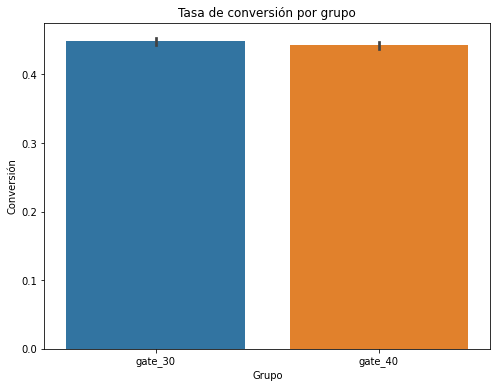

In [21]:
plt.figure(figsize=(8,6))

sns.barplot(x=ret1['version'], 
            y=ret1['retention_1'], 
            ci=95
           )
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Conversión');

# testeo para retention_7



In [24]:
control_7=ret2[ret2.version=='gate_30']

tratamiento_7=ret2[ret2.version=='gate_40']
tasas_conversion_7=ret2.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)            
error_std=lambda x: stats.sem(x, ddof=0)    

tasas_conversion_7=tasas_conversion_7.agg([np.mean, std, error_std])

tasas_conversion_7.columns=['conv_rate', 'std', 'error_std']

tasas_conversion_7.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


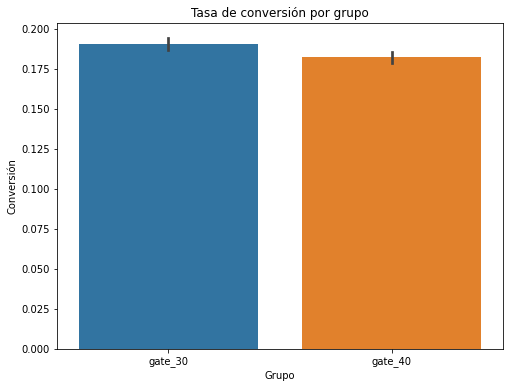

In [26]:
plt.figure(figsize=(8,6))

sns.barplot(x=ret2['version'], 
            y=ret2['retention_7'], 
            ci=95
           )
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Conversión');